### Load modules

In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import numpy as np
import os
import glob
import pandas as pd 
import h5py
import pickle
import cv2 as cv

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.signal as signal
from scipy.interpolate import LinearNDInterpolator, griddata
from datetime import datetime,timedelta
import pytz

import icewave.tools.matlab2python as mat2py
import icewave.sebastien.set_graphs as set_graphs
import icewave.drone.drone_projection as dp
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.rw_data as rw

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load stereo data

In [61]:
date = '0211'
path2data = f'K:/Share_hublot/Data/{date}/Drones/'
file2load = f'{path2data}real_field_stereo_0211_2024_rectangular_grid.h5'
u_struct = rw.load_dict_from_h5(file2load)
print('Stereo data loaded')

Stereo data loaded


### Define fig_folder

In [64]:
fig_folder = f'{path2data}stereo_figures/'
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)

### Load buoys tracking

In [3]:
file2load = f'{path2data}structure_buoys_tracking_3drones.pkl'
with open(file2load,'rb') as pf:
    Z = pickle.load(pf)

# Create a colormap for each drone 

maps = {'fulmar':'Blues','bernache':'Oranges','mesange':'Greens'}
maps_drone = {}
for key_drone in maps.keys():
    maps_drone[key_drone] = {}
    full_map = mpl.colormaps[maps[key_drone]].resampled(256)
    new_map = mcolors.ListedColormap(full_map(np.linspace(0.2,1,256)))
    cnorm = mcolors.Normalize(vmin = 0, vmax = 5)
    cnorm_time = mcolors.Normalize(vmin = 0, vmax = Z[key_drone]['t'].max())
    maps_drone[key_drone]['new_map'] = new_map
    maps_drone[key_drone]['cnorm'] = cnorm
    maps_drone[key_drone]['cnorm_time'] = cnorm_time

### Load synchronization file

In [20]:
filename = f'{path2data}synchro_3drones.pkl'

with open(filename,'rb') as pf:
   synchro = pickle.load(pf)

### Load buoys data

In [4]:
path2buoys = f'K:/Share_hublot/Data/{date}/BoueeVague/'
filelist = glob.glob(f'{path2buoys}B*')
buoy_files = []
for buoy_folder in filelist:
    folder = f'{buoy_folder}/mat/'
    current_file = glob.glob(f'{folder}*2000.mat')
    if not current_file :
        print('filelist is empty')
    else : 
        buoy_files.append(current_file[0])


# keep only buoys #1, #4 and #5
buoy_files = [buoy_files[0],buoy_files[2],buoy_files[3]]

buoy_ref = {'0':'B1','1':'B4','2':'B5'}
data_buoy = {}
for i in range(len(buoy_files)):
    file2load = buoy_files[i]
    with h5py.File(file2load, 'r') as fmat:
        print('Top-level keys : ', list(fmat.keys()))
        
        key_buoy = buoy_ref[str(i)]
        data_buoy[key_buoy] = mat2py.mat_to_dict(fmat['IMU'],fmat['IMU'])

filelist is empty
filelist is empty
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']


In [112]:
data_buoy['B5']['IMU_DATA'].keys()

dict_keys(['ACCEL_X', 'ACCEL_Y', 'ACCEL_Z', 'CRC', 'CRC_CALC', 'DATA_VEL_X', 'DATA_VEL_Y', 'DATA_VEL_Z', 'DELTA_ANGLE_X', 'DELTA_ANGLE_Y', 'DELTA_ANGLE_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z', 'IMU_STATUS', 'TEMP', 'TIME_STAMP', 'TS_fix', 't', 'time'])

### Create a dictionnary of velocity for each buoys

In [10]:
UTC_buoy = {}
u_buoy = {}

# build a filter for buoys
fs = 50 # sampling frequency
fc = 0.1 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'high',fs = fs)

# define acceleration keys
key_accel = ['ACCEL_X','ACCEL_Y','ACCEL_Z']
key_ufield = ['ux','uy','uz']
for key in data_buoy.keys():
    
    UTC_buoy[key] = []
    # Build UTC time for buoys
    Y = int(data_buoy[key]['UTC_TIME']['YEAR'][0])
    M = int(data_buoy[key]['UTC_TIME']['MONTH'][0])
    D = int(data_buoy[key]['UTC_TIME']['DAY'][0])
    H = int(data_buoy[key]['UTC_TIME']['HOUR'][0])
    MIN = int(data_buoy[key]['UTC_TIME']['MIN'][0])
    SEC = int(data_buoy[key]['UTC_TIME']['SEC'][0])

    # initial UTC time for buoys
    UTC0 = datetime(Y,M,D,H,MIN,SEC)
    t0_epoch = UTC0.timestamp()
    t_epoch = t0_epoch + data_buoy[key]['IMU_DATA']['t']

    for t in t_epoch:
        if not np.isnan(t):
            UTC_buoy[key].append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))

    mask = ~np.isnan(t_epoch)

    # u_buoy[key] = {}
    current_u = np.array([data_buoy[key]['IMU_DATA'][key_a][mask] for key_a in key_accel])
    # Apply filter to signal 
    current_u = signal.filtfilt(b,a,current_u,axis = -1)
    # Compute vertical velocity
    u_buoy[key] = np.cumsum(current_u - np.mean(current_u,axis = -1,keepdims = True),axis = -1)/fs

### Interpolate velocity along trajectory of buoys

In [83]:
for key in data_buoy.keys():
    buoy_idx = int(key[-1])-1
    print(buoy_idx)

0
3
4


In [84]:
points = np.array([u_struct['X'].ravel(),u_struct['Y'].ravel()]).T

ref_drone = u_struct['ref_drone']
i0 = synchro[ref_drone]
buoys_names = ['B1','B4','B5']

interp_u = {}

for key_buoy in data_buoy.keys():
    buoy_idx = int(key_buoy[-1])-1
    x_obj = Z[ref_drone]['real'][buoy_idx,0,i0:]
    y_obj = Z[ref_drone]['real'][buoy_idx,1,i0:]

    interp_u[key_buoy] = np.zeros((u_struct['u'].shape[0],u_struct['u'].shape[3]))
    
    for frame in range(interp_u[key_buoy].shape[1]):
        for i in range(interp_u[key_buoy].shape[0]):
            interp_u[key_buoy][i,frame] = griddata(points, u_struct['u'][i,:,:,frame].ravel(), 
                                   (x_obj[frame],y_obj[frame]),method = 'linear')
            
    print(f'{key_buoy} processed !')
        
# griddata(np.array(ref_points), data[ref_drone]['Vx'][:,:,frame].ravel(), 
#                           (grid_x,grid_y),method = 'linear')

B1 processed !
B4 processed !
B5 processed !


### Filter interpolated velocities

In [74]:
interp_u['B1'].shape

(3, 3475)

In [85]:
# filter drone signal
fs = 30 # sampling frequency
fc = 1 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'low',fs = fs)

# Apply filter to signal 
filtered_u = {}
for key_buoy in interp_u.keys():
    filtered_u[key_buoy] = signal.filtfilt(b,a,interp_u[key_buoy],axis = -1)

In [86]:
filename = f'{path2data}interpolated_u_over_buoys_traj_{date}_2024.h5'
rw.save_dict_to_h5(filtered_u,filename)

### Apply time shift to interpolated $\vec{u}$ to synchronize with buoys data

In [87]:
# UTC0 of videos
UTC0_drone = {'bernache' : datetime(2024,2,11,20,35,11,690000),
              'mesange' : datetime(2024,2,11,20,35,10,589000)}
fps = 30 # frame rate of each drone
# create new UTC0 based on drone synchronization with fulmar

for key_drone in UTC0_drone.keys():
    delta_t = synchro[key_drone]/fps
    t0 = UTC0_drone[key_drone].timestamp()
    new_t0 = datetime.fromtimestamp(t0 + delta_t).replace(tzinfo = pytz.utc)
    
    UTC0_drone[key_drone] = new_t0
    
# compute UTC_t for drones, based on UTC0 of bernache
ref_time = 'bernache'
t_drone = np.arange(0,u_struct['u'].shape[3])/fps
UTC_drone = []
for t in t_drone:
    t_epoch = UTC0_drone['bernache'].timestamp() + t
    UTC_drone.append(datetime.utcfromtimestamp(t_epoch).replace(tzinfo = pytz.utc))

UTC_drone = np.array(UTC_drone)

# apply time shift to synchronize drones and buoys
file2load = f'{path2data}Buoy_drone_synchro_time_delta_i0_520.pkl'

with open(file2load,'rb') as pf:
    synchro_buoy_drone = pickle.load(pf)

UTC_drone = UTC_drone + synchro_buoy_drone['shift_timedelta']

In [79]:
synchro_buoy_drone

{'shift_timedelta': datetime.timedelta(days=-1, seconds=86379, microseconds=61667),
 'shift_seconds': -20.938333,
 'to_be_applied': 'drone',
 'initial_frame_drone': 520}

### Compare velocity fields

In [51]:
fig_folder_buoys = f'{fig_folder}buoys_comparison/'
if not os.path.isdir(fig_folder_buoys):
    os.mkdir(fig_folder_buoys)

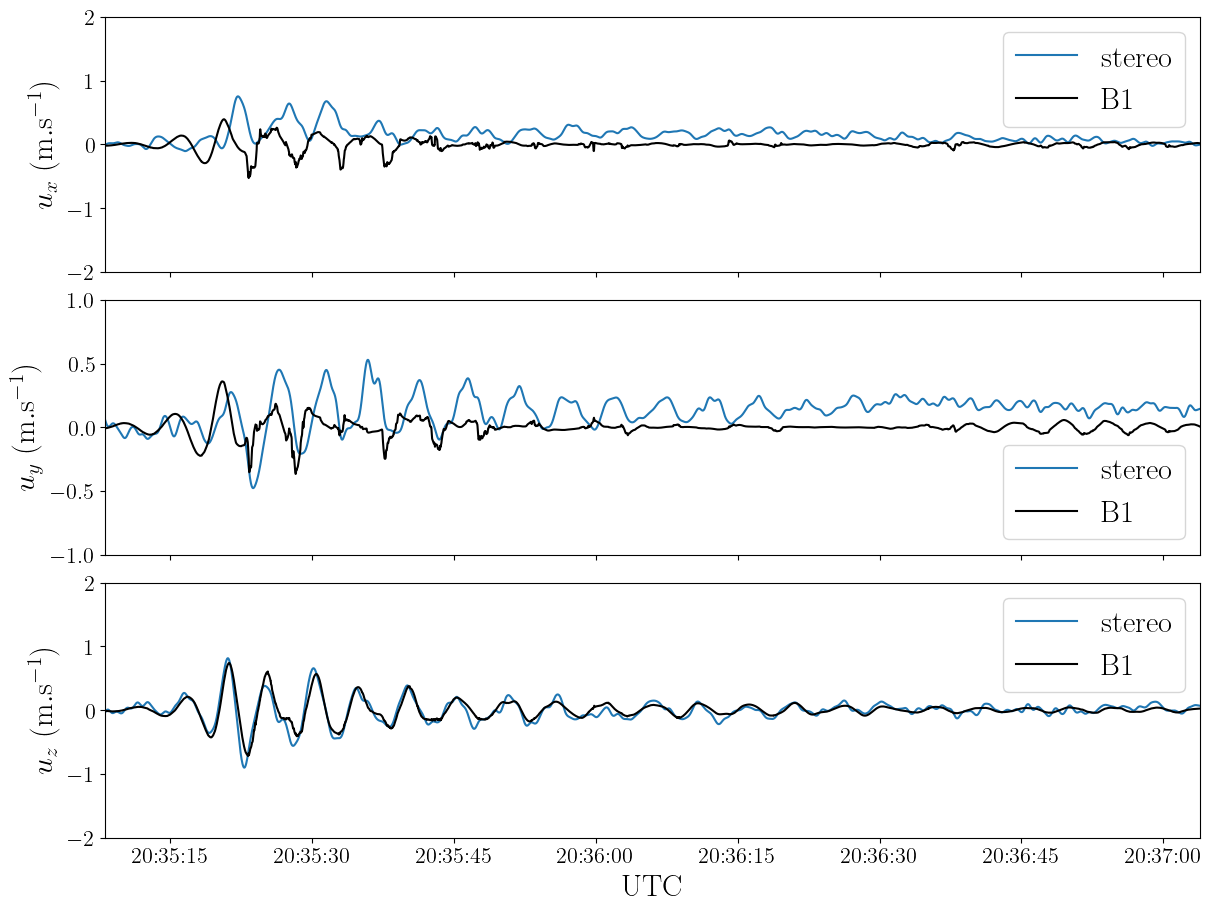

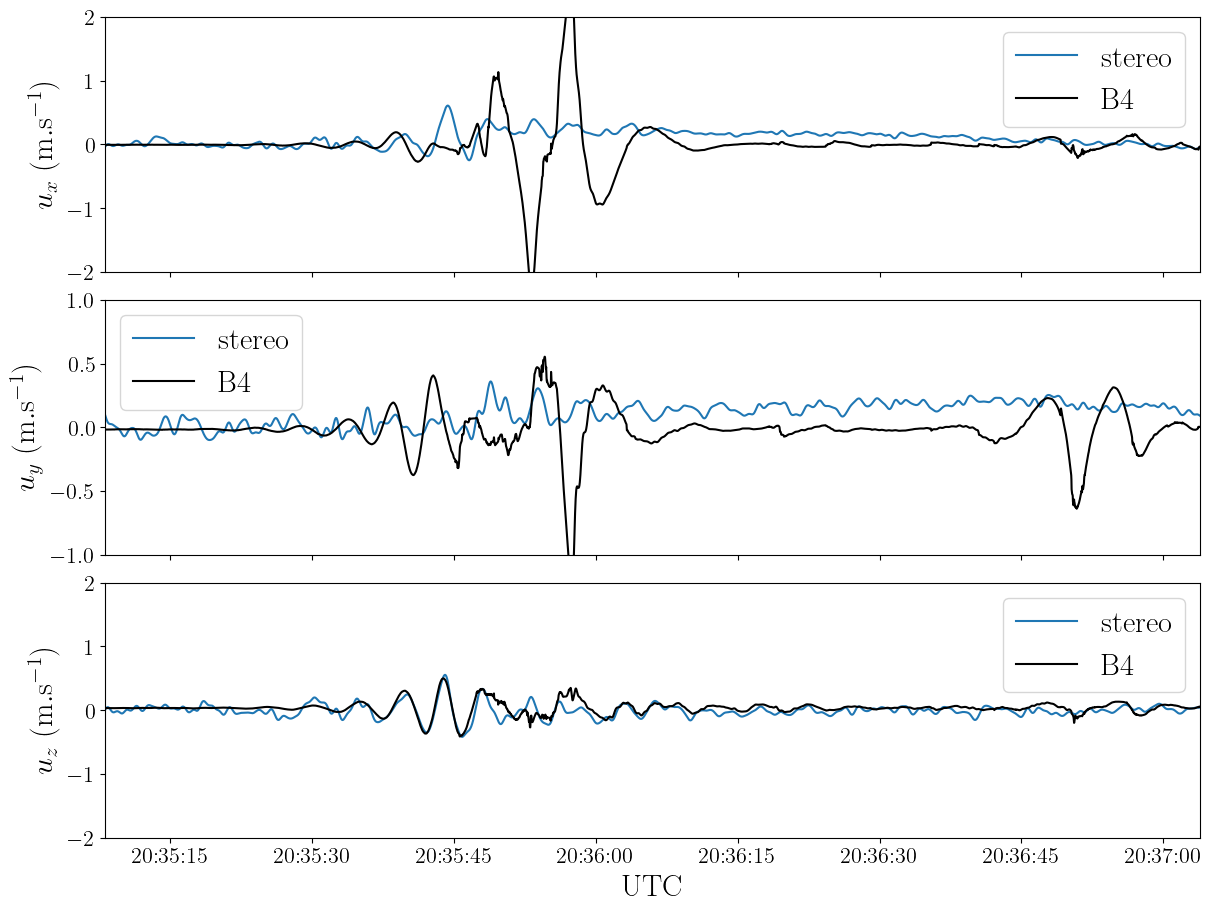

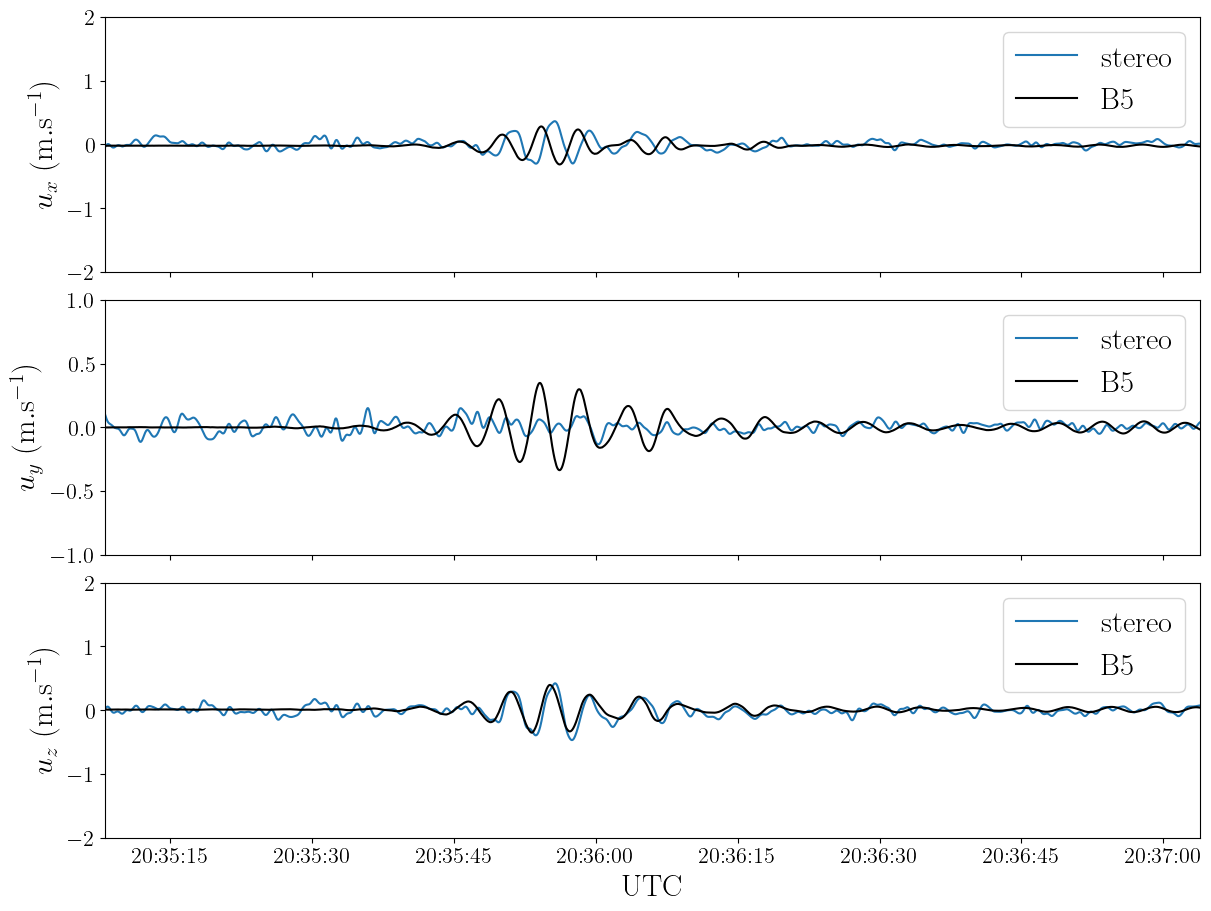

In [88]:
type_signal = 'filtered'

# ylim = {'B5' : [-0.6,0.6],'B4': [-0.9,0.9], 'B1': [-1.5,1.5]}
Dt = 4
scaling_factor = u_struct['SCALE']['facq_t']/Dt
for key_buoy in filtered_u.keys():
    
    set_graphs.set_matplotlib_param('single')
    fig, axs = plt.subplots(figsize = (12,9), nrows = 3, sharex = True, layout = 'constrained')
    for i in range(len(axs)):
        axs[i].plot(UTC_drone,filtered_u[key_buoy][i,:],'-',label = 'stereo')
        axs[i].plot(UTC_buoy[key_buoy],u_buoy[key_buoy][i,:],'k-',label = key_buoy)
        axs[i].legend()
        axs[i].set_xlim([UTC_drone[0] , UTC_drone[-1]])
    
    axs[2].set_xlabel(r'UTC')
    axs[0].set_ylabel(r'$u_x \; \mathrm{(m.s^{-1})}$')
    axs[1].set_ylabel(r'$u_y \; \mathrm{(m.s^{-1})}$')
    axs[2].set_ylabel(r'$u_z \; \mathrm{(m.s^{-1})}$')
    
    # set ylim
    axs[0].set_ylim([-2,2])
    axs[1].set_ylim([-1,1])
    axs[2].set_ylim([-2,2])
    
    figname = f'{fig_folder_buoys}{key_buoy}_u_buoy_VS_u_stereo_interpolated_trajectory'
    plt.savefig(f'{figname}.png', bbox_inches = 'tight')
    plt.savefig(f'{figname}.pdf', bbox_inches = 'tight')
    plt.savefig(f'{figname}.svg', bbox_inches = 'tight')

Text(0, 0.5, '$u_{||} \\; \\mathrm{(m.s^{-1})}$')

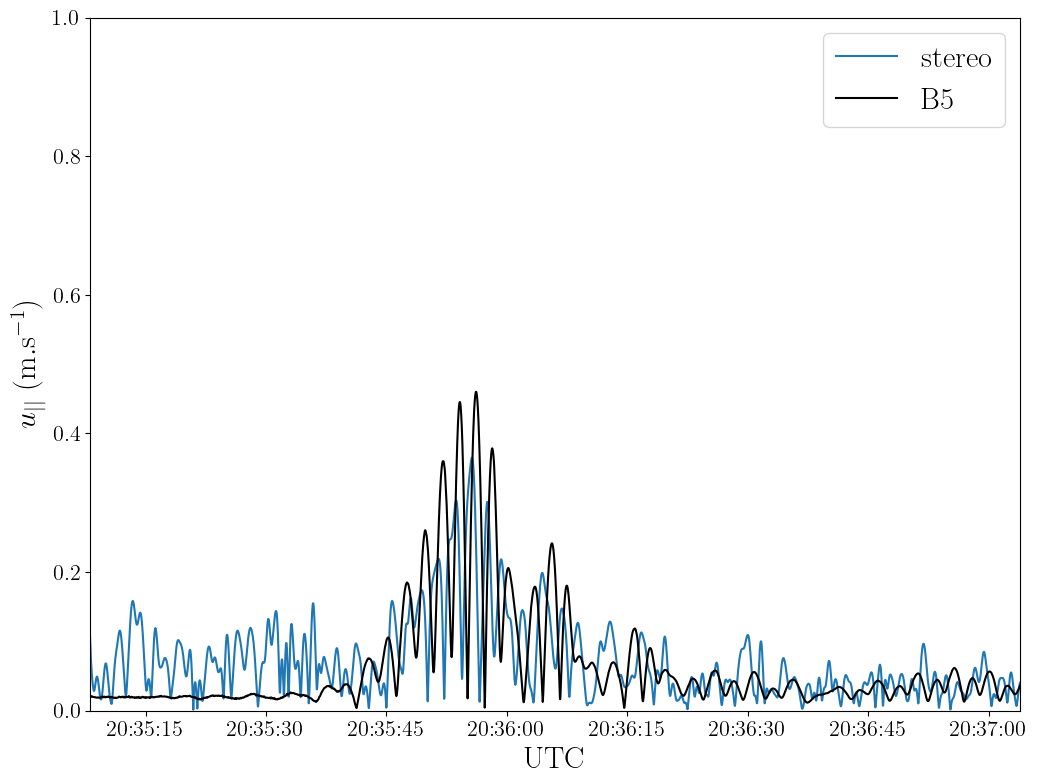

In [92]:
key_buoy = 'B5'

u_stereo_horiz = np.sqrt(filtered_u[key_buoy][0,:]**2 + filtered_u[key_buoy][1,:]**2)
u_buoy_horiz = np.sqrt(u_buoy[key_buoy][0,:]**2 + u_buoy[key_buoy][1,:]**2)

fig, ax = plt.subplots(figsize = (12,9))
ax.plot(UTC_drone,u_stereo_horiz,'-', label = 'stereo')
ax.plot(UTC_buoy[key_buoy],u_buoy_horiz,'-', color = 'k', label = key_buoy)
ax.legend()
ax.set_xlim([UTC_drone[0] , UTC_drone[-1]])
ax.set_ylim([0,1])

ax.set_xlabel(r'UTC')
ax.set_ylabel(r'$u_{||} \; \mathrm{(m.s^{-1})}$')

### Focus on Buoy 5 - compare buoy data and observed wave field at the mean position

In [144]:
## Mean position of buoy 5
i0 = synchro[ref_drone]
key_buoy = 'B1'
buoy_idx = int(key_buoy[-1])-1

mean_pos = np.mean(Z[ref_drone]['real'][buoy_idx,:,i0:],axis = 1)
print(mean_pos)

## get closest box to this position
dist = [(x - mean_pos[0])**2 + (y - mean_pos[1])**2 for (x,y) in zip(u_struct['X'].ravel(),u_struct['Y'].ravel())]
idx = np.argmin(dist)
row,col = np.unravel_index(idx,u_struct['X'].shape)

[37.80562121  3.97814379]


### Compare buoy 5 and stereo at the mean position of buoy 5 (no interpolation)

(-2.0, 2.0)

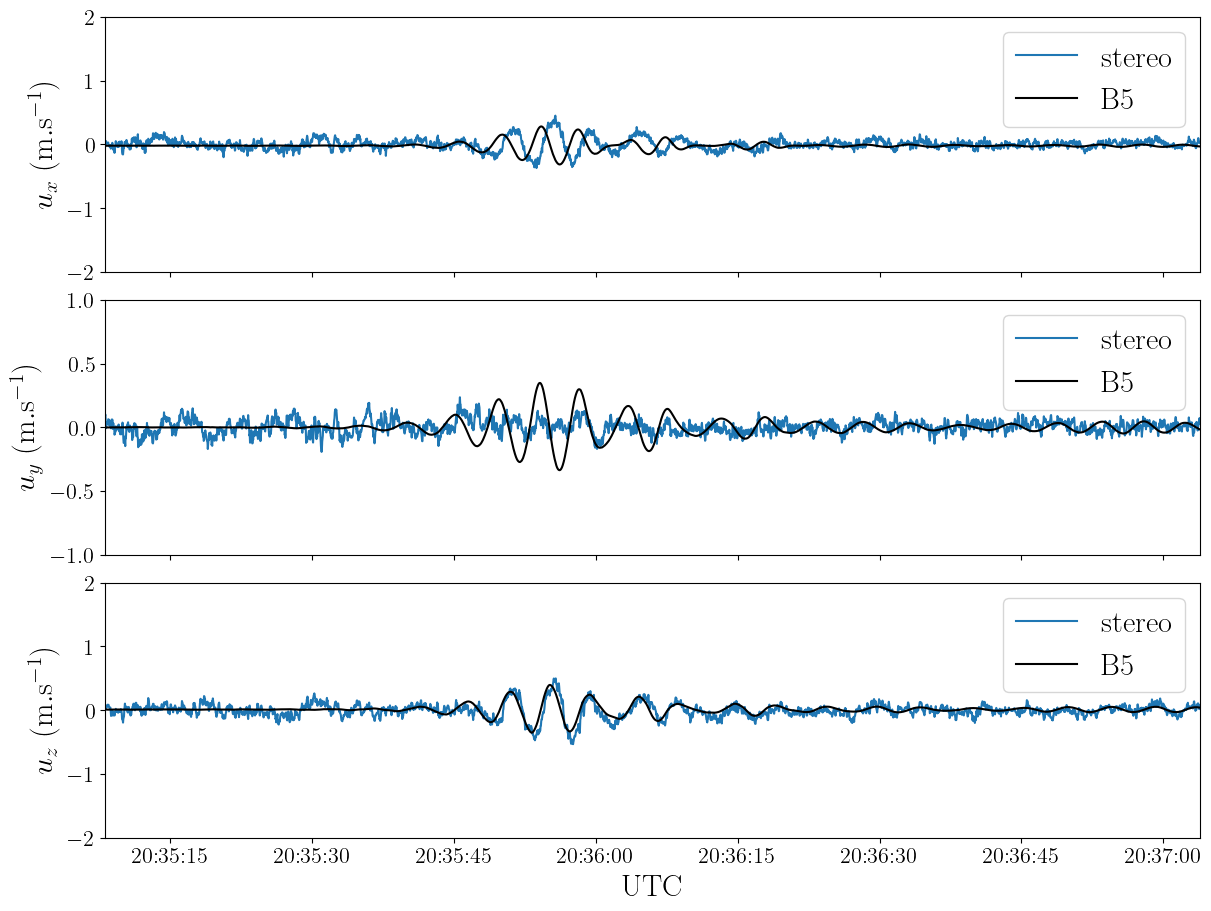

In [125]:
set_graphs.set_matplotlib_param('single')
fig, axs = plt.subplots(figsize = (12,9), nrows = 3, sharex = True, layout = 'constrained')
for i in range(len(axs)):
    axs[i].plot(UTC_drone,u_struct['u'][i,row,col,:],'-',label = 'stereo')
    axs[i].plot(UTC_buoy[key_buoy],u_buoy[key_buoy][i,:],'k-',label = key_buoy)
    axs[i].legend()
    axs[i].set_xlim([UTC_drone[0] , UTC_drone[-1]])

axs[2].set_xlabel(r'UTC')
axs[0].set_ylabel(r'$u_x \; \mathrm{(m.s^{-1})}$')
axs[1].set_ylabel(r'$u_y \; \mathrm{(m.s^{-1})}$')
axs[2].set_ylabel(r'$u_z \; \mathrm{(m.s^{-1})}$')

# set ylim
axs[0].set_ylim([-2,2])
axs[1].set_ylim([-1,1])
axs[2].set_ylim([-2,2])

### Superpose $u_x$, $u_y$ and $u_z$ computed by stereo at the mean position of B5

Text(0.5, 0, 'UTC')

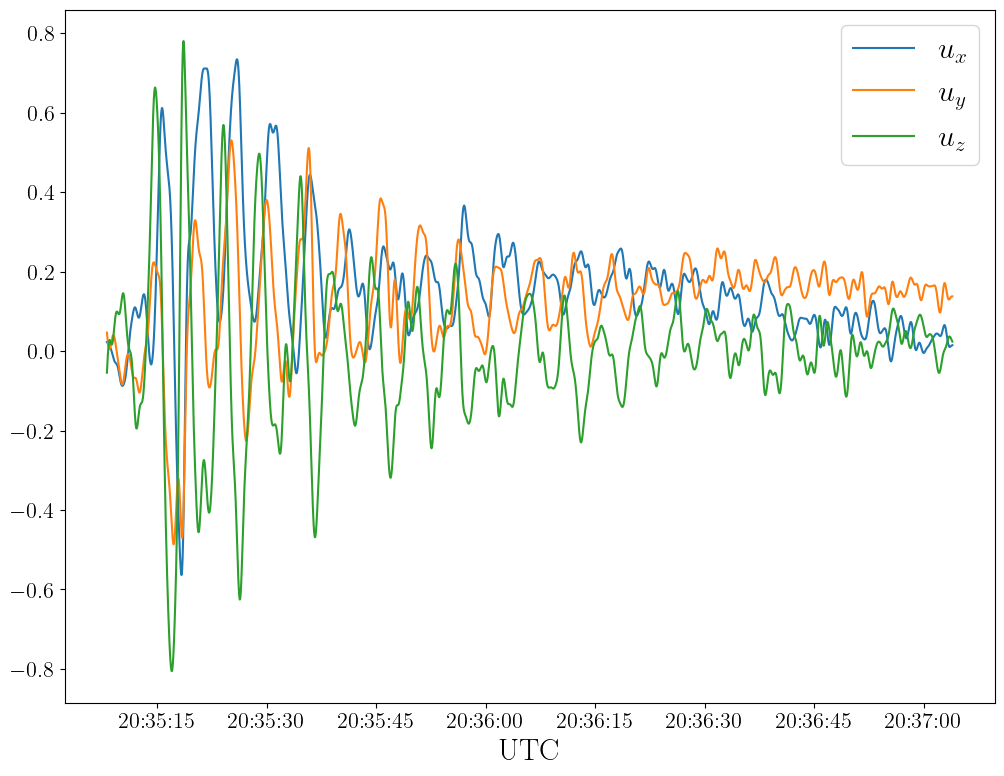

In [145]:
# filter drone signal
fs = 30 # sampling frequency
fc = 1 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'low',fs = fs)

u_stereo = signal.filtfilt(b,a,u_struct['u'][:,row,col,:],axis = -1)

labels_u = [r'$u_x$',r'$u_y$',r'$u_z$']

fig, ax = plt.subplots(figsize = (12,9))
for i in range(u_stereo.shape[0]):
    ax.plot(UTC_drone,u_stereo[i,:],'-',label = labels_u[i])
    
ax.legend()
ax.set_xlabel('UTC')




In [132]:
u_struct['SCALE']

{'facq_t': np.float64(29.97),
 'facq_x': np.float64(1.25),
 'scaling_factor_V': np.float64(7.4925),
 'units': {'facq_t': 'Hz', 'facq_x': 'box/meter'}}

### Superpose buoys $u_x$, $u_y$, $u_z$

(-1.0, 1.0)

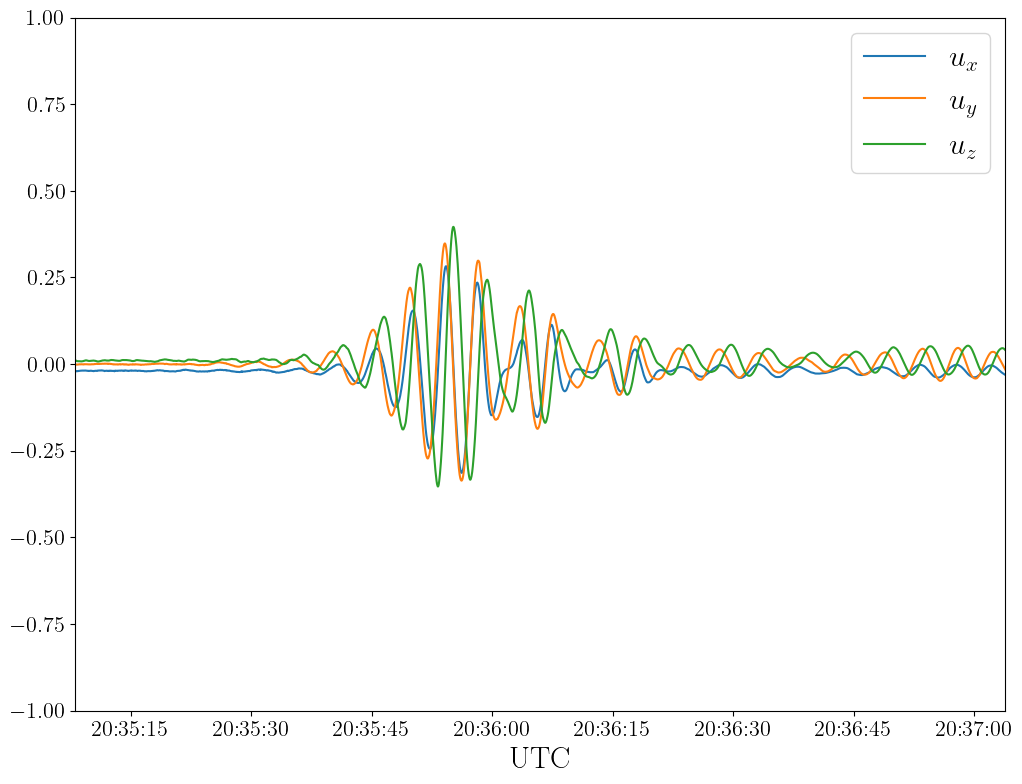

In [135]:
labels_u = [r'$u_x$',r'$u_y$',r'$u_z$']

key_buoy = 'B5'

fig, ax = plt.subplots(figsize = (12,9))
for i in range(u_stereo.shape[0]):
    ax.plot(UTC_buoy[key_buoy],u_buoy[key_buoy][i,:],'-',label = labels_u[i])
ax.legend()
ax.set_xlabel('UTC')
ax.set_xlim([UTC_drone[0] , UTC_drone[-1]])
ax.set_ylim([-1,1])

### Plot velocity recorded by buoys (not integrated with Python)

In [138]:
DATA_vel_buoy = {}

# build a filter for buoys
fs = 50 # sampling frequency
fc = 0.1 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'high',fs = fs)

# define acceleration keys
key_vec = ['DATA_VEL_X','DATA_VEL_X','DATA_VEL_X']

for key in data_buoy.keys():
    
    UTC_buoy[key] = []
    # Build UTC time for buoys
    Y = int(data_buoy[key]['UTC_TIME']['YEAR'][0])
    M = int(data_buoy[key]['UTC_TIME']['MONTH'][0])
    D = int(data_buoy[key]['UTC_TIME']['DAY'][0])
    H = int(data_buoy[key]['UTC_TIME']['HOUR'][0])
    MIN = int(data_buoy[key]['UTC_TIME']['MIN'][0])
    SEC = int(data_buoy[key]['UTC_TIME']['SEC'][0])

    # initial UTC time for buoys
    UTC0 = datetime(Y,M,D,H,MIN,SEC)
    t0_epoch = UTC0.timestamp()
    t_epoch = t0_epoch + data_buoy[key]['IMU_DATA']['t']

    for t in t_epoch:
        if not np.isnan(t):
            UTC_buoy[key].append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))

    mask = ~np.isnan(t_epoch)

    # u_buoy[key] = {}
    current_u = np.array([data_buoy[key]['IMU_DATA'][key_a][mask] for key_a in key_vec])
    # Apply filter to signal 
    current_u = signal.filtfilt(b,a,current_u,axis = -1)
    # Substract average
    DATA_vel_buoy[key] = current_u - np.mean(current_u,axis = -1,keepdims = True)

(-1.0, 1.0)

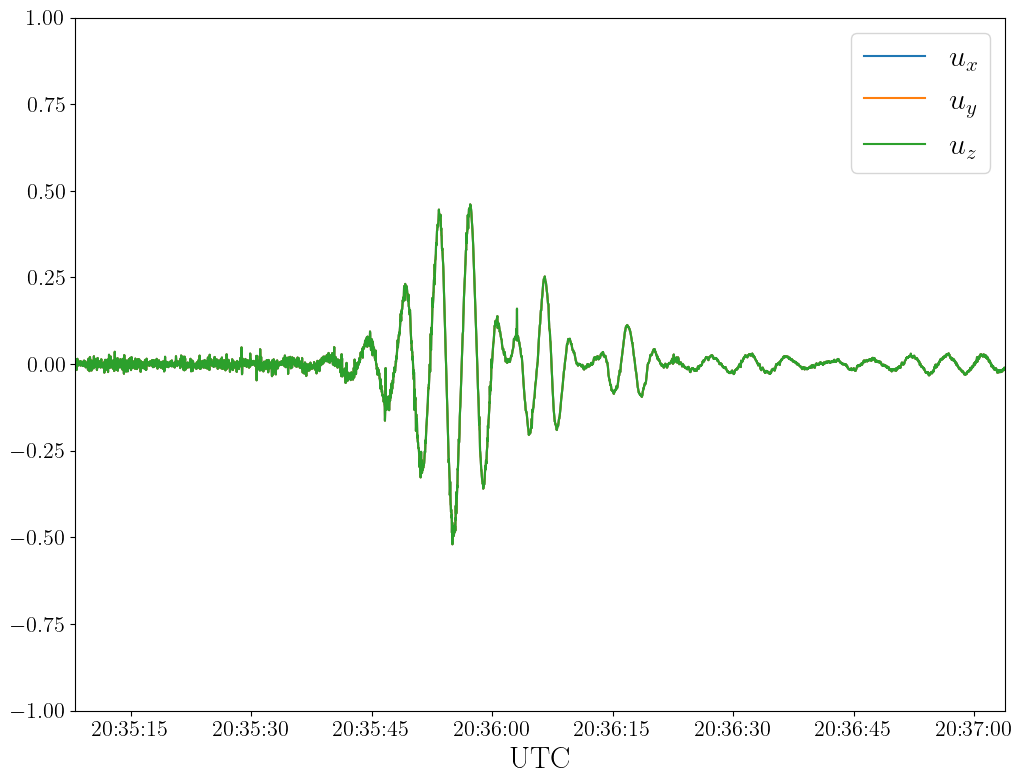

In [143]:
labels_u = [r'$u_x$',r'$u_y$',r'$u_z$']

key_buoy = 'B5'

fig, ax = plt.subplots(figsize = (12,9))
for i in range(u_stereo.shape[0]):
    ax.plot(UTC_buoy[key_buoy],DATA_vel_buoy[key_buoy][i,:],'-',label = labels_u[i])
ax.legend()
ax.set_xlabel('UTC')
ax.set_xlim([UTC_drone[0] , UTC_drone[-1]])
ax.set_ylim([-1,1])